### Installation of required packages

In [1]:
! pip install psutil pandas pynvml tqdm line_profiler matplotlib seaborn
! pip install pyahocorasick Bio pybmoore ahocorasick_rs

# pip install requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Imports and initialization

In [2]:
#import pytest
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

import time
import psutil
import logging
import os
import sys
import platform

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count

from collections import defaultdict
from Bio import SeqIO #type: ignore

### Data for benchmarking

In [3]:
from Bio import SeqIO

def load_peptides_txt(path):
    with open(path) as f:
        return [l.strip() for l in f if l.strip()]

def load_proteome_fasta(path):
    """
    Retourne une liste de tuples (protein_id, sequence)
    """
    return [(rec.id, str(rec.seq)) for rec in SeqIO.parse(path, "fasta")]


In [19]:
peptides = load_peptides_txt("Peptides.txt")

proteome = load_proteome_fasta(
    "uniprotkb_proteome_UP000000803_2025_11_25.fasta"
)

proteome_fasta_path = "uniprotkb_proteome_UP000000803_2025_11_25.fasta"

In [5]:
#boyer moore spec
import tempfile
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# Pour Boyer-Moore multiprocessing version qui attend (id, seq)
queries = [(pep, pep) for pep in peptides]  # id = sequence

# Créer un FASTA temporaire pour le proteome
proteome_fasta_file = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.fasta')
records = [SeqRecord(Seq(seq), id=pid) for pid, seq in proteome]
SeqIO.write(records, proteome_fasta_file.name, "fasta")
proteome_fasta_file.close()

### Matching algorithms to benchmark 

In [6]:
import pybmoore 

import ahocorasick
from ahocorasick_rs import AhoCorasick
import subprocess
import tempfile
import os
import shutil as sh

In [ ]:
### bash commands makeblastdb and blastp must be installed and on PATH
! sudo apt update
! sudo apt install ncbi-blast+

[sudo] password for meredithbf: 

In [7]:
from bench_functions import (
    run_ahocorasick_mem,
    run_ahocorasick_rs_mem,
    run_find_mem,
    run_in_mem,
    run_blast_mem,
    run_boyermoore_parallel_mem,
    run_grawk_mem2
    )


In [20]:
# Exemple de texte et motifs
#text = "A" * 1000 + "B" * 500 + "ABCABCABC" * 100
#patterns_single = "ABC"
#patterns_multiple = ["A", "B", "C", "ABC", "BC", "AB"]

TESTS = [
    (run_ahocorasick_mem, (peptides, proteome)),  # note le tuple comme argument
    (run_ahocorasick_rs_mem, (peptides, proteome)),
    (run_find_mem, (peptides, proteome)),
    (run_in_mem, (peptides, proteome)),
    (run_blast_mem, (peptides, proteome_fasta_path)),
    (run_boyermoore_parallel_mem, (queries, proteome_fasta_file.name)),
    (run_grawk_mem2, (peptides, proteome))
]

In [10]:
# Check WSL availability
#if platform.system() == "Windows":
    #try:
        #subprocess.run(["wsl", "--version"], capture_output=True, check=True, timeout=5)
        #TESTS.append((run_grawk_mem_wsl, (peptides, proteome)))
        #print("✓ WSL detected")
    #except (FileNotFoundError, subprocess.TimeoutExpired):
        #print("⚠ WSL not available - skipping grawk_mem_wsl")

In [21]:
# Logging configuration: write execution details to a log file
logging.basicConfig(
    filename="benchmark.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

process = psutil.Process()

### Single-run measurement utility

In [22]:
def run_once(fn, *args, **kwargs):
    """
    Execute a function once and collect basic timing and memory information.
    This is decorator-free to ensure functions remain pickleable.
    """
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)
    t1 = time.perf_counter()

    mem = process.memory_info().rss / 1e6

    return {
        "time_seconds": t1 - t0,
        "memory_used_MB": mem,
        "result": result
    }

### Multi-run wrapper (manual loop)

In [23]:
def benchmark(fn, runs=5, args=()):
    """
    Run a function several times with positional arguments and compute average runtime.
    No decoration or wrapping done, to keep fn pickleable.
    """
    records = []
    for _ in range(runs):
        rec = run_once(fn, *args)  # dépaqueter le tuple
        records.append(rec)

    avg_time = sum(r["time_seconds"] for r in records) / len(records)

    return {
        "function": fn.__name__,
        "args": args,
        "time_mean": avg_time,
    }



### Sequential execution 

In [24]:
results_seq = []
for fn, params in TESTS:
    res = benchmark(fn, runs=5, args=params)  # <- args=params, no *
    logging.info(f"[SEQ] {res}")
    results_seq.append(res)

df_seq = pd.DataFrame(results_seq)
df_seq


RuntimeError: makeblastdb and blastp must be installed and on PATH

### Metrics

In [ ]:
def run_single_with_metrics(test):
    func, args = test # args can be a tuple or a dict
    if isinstance(args, dict):
        args = (args.get("size", 0),)  # -> tuple
    elif not isinstance(args, tuple):
        args = (args,)  # transform in tuple if only 1 argument

    proc = psutil.Process(os.getpid())
    cpu_start = psutil.cpu_percent(interval=None)
    mem_start = proc.memory_info().rss / (1024*1024)  # en MB

    import time
    start = time.time()
    result = func(*args)
    end = time.time()

    cpu_end = psutil.cpu_percent(interval=None)
    mem_end = proc.memory_info().rss / (1024*1024)  # en MB

    return {
        "result": result,
        "time_sec": end - start,
        "cpu_mean": cpu_end - cpu_start,
        "mem_mean_MB": mem_end - mem_start
    }

### DataFrame creation

In [ ]:
# Exécution parallèle avec ThreadPoolExecutor (safe dans Jupyter)
with ThreadPoolExecutor(max_workers=cpu_count()) as exe:
    results = list(exe.map(run_single_with_metrics, TESTS))

df_parallel = pd.DataFrame({
    "function": [t[0].__name__ for t in TESTS],
    "argument": [t[1] for t in TESTS],
    "result": [r["result"] for r in results],
    "time_sec": [r["time_sec"] for r in results],
    "cpu_mean": [r["cpu_mean"] for r in results],
    "mem_mean_MB": [r["mem_mean_MB"] for r in results]
})

print(df_parallel.columns)



Index(['function', 'argument', 'result', 'time_sec', 'cpu_mean',
       'mem_mean_MB'],
      dtype='object')


### Visualisation of results (boxplot + violin)

<Figure size 640x480 with 0 Axes>

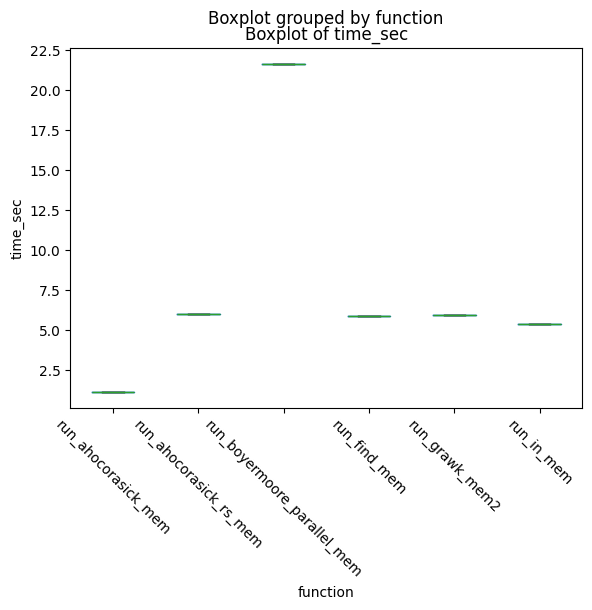

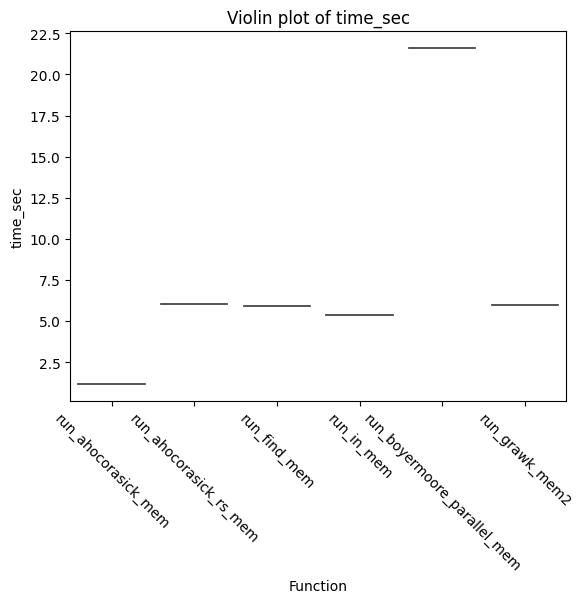

<Figure size 640x480 with 0 Axes>

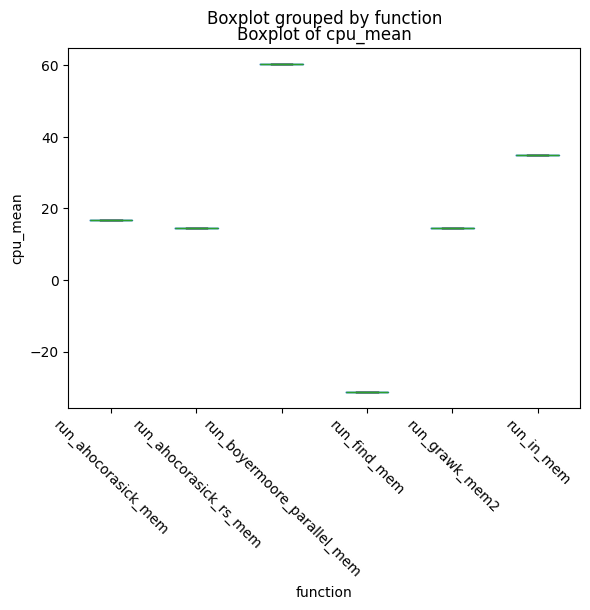

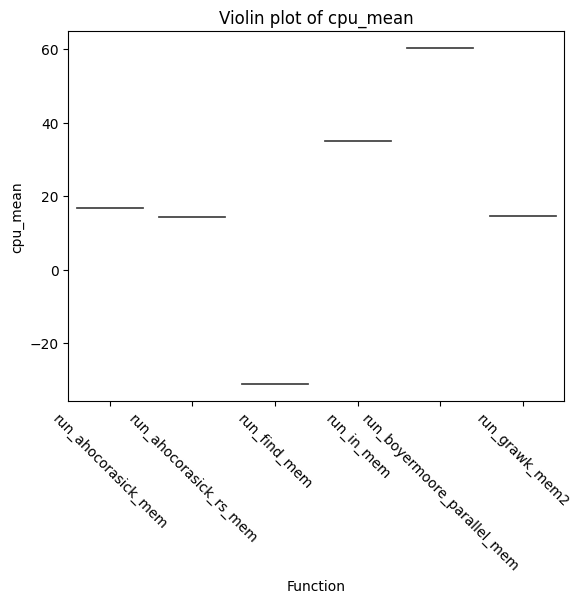

<Figure size 640x480 with 0 Axes>

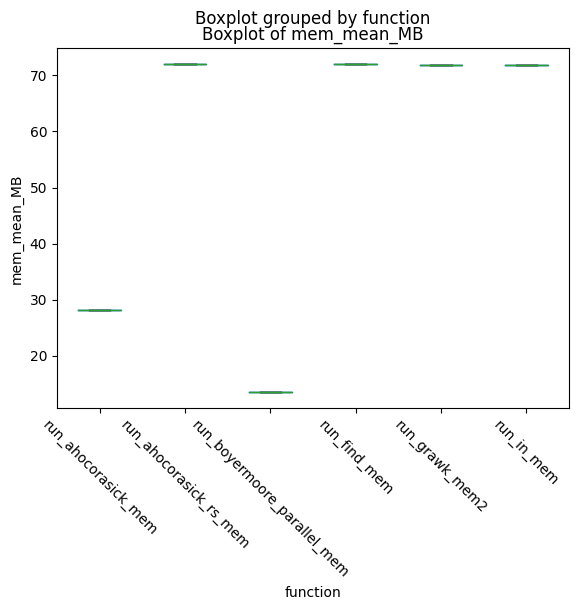

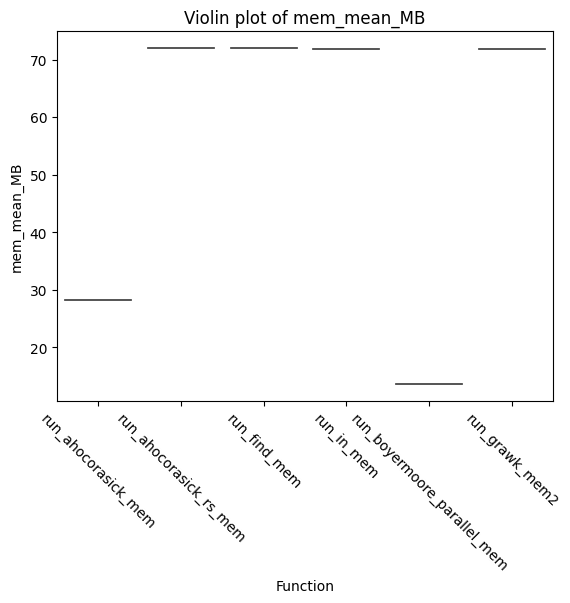

In [ ]:
metrics = ["time_sec", "cpu_mean", "mem_mean_MB"]

for m in metrics:
    # Boxplot avec Pandas
    plt.figure()
    ax = df_parallel.boxplot(column=[m], by="function", grid=False)
    plt.title(f"Boxplot of {m}")
    plt.xlabel("function")
    plt.ylabel(m)
    plt.xticks(rotation=-45)
    plt.show()

    # Violin plot avec Seaborn
    plt.figure()
    ax = sns.violinplot(x="function", y=m, data=df_parallel)
    plt.title(f"Violin plot of {m}")
    ax.set_xlabel("Function")
    ax.set_ylabel(m)
    plt.xticks(rotation=-45)
    plt.show()


### Export results

In [ ]:
df_seq.to_csv("bench_seq.csv", index=False)
df_parallel.to_csv("bench_parallel.csv", index=False)
print("Benchmark exports complete.")


Benchmark exports complete.
